In [1]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df = pd.read_csv('C:/Users/VISHRUTH NIMALAN/Downloads/archive/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'overall_sentiment'])
df.head()

image_name                                     text_corrected  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearChallenge! Completed in le...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

       humour          sarcasm       offensive      motivational  
0   hilarious          general   not_offensive  not_motivational  
1   not_funny          general   not_offensive      motivational  
2  very_funny    not_sarcastic   not_offensive  not_motivational  
3  very_funny  twisted_meaning  very_offensive      motivational  
4   hilarious     very_twisted  very_offensive  not_motivational

In [3]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1}})

In [4]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name        False
text_corrected    False
humour            False
sarcasm           False
offensive         False
motivational      False
dtype: bool

In [5]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'C:/Users/VISHRUTH NIMALAN/Downloads/archive/memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)

X = np.array(X)

 95%|█████████▌| 6669/6987 [00:32<00:01, 249.90it/s]d:\Python_Installation\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6987/6987 [00:34<00:00, 204.08it/s]


In [6]:
X.shape

(6982, 100, 100, 3)

In [7]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [8]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [9]:
target = cleaned.iloc[:,2:]
target.head()

humour  sarcasm  offensive  motivational
0       3        1          0             0
1       0        1          0             1
2       2        0          0             0
3       2        2          2             1
4       3        3          2             0

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


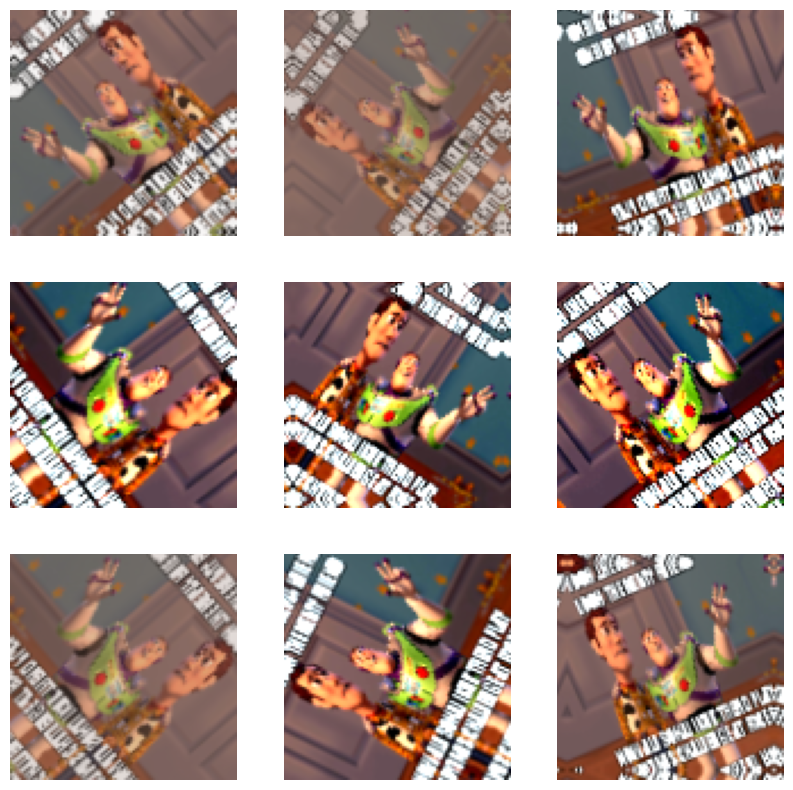

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [13]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
base_model_1.trainable = False
base_model_2.trainable = False

In [15]:
def image_model():
    # Define input layer
    image_input = tf.keras.Input(shape=(100, 100, 3), name='image_input')

    # Data augmentation and preprocessing
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)

    # Process through base_model_1
    layer_bm_1 = base_model_1(image_layers, training=False)
    dropout_layer = Dropout(0.2)(layer_bm_1)
    layer_bm_1 = Conv2D(2048, kernel_size=2, padding='valid')(layer_bm_1)
    dropout_layer = Dropout(0.3)(layer_bm_1)
    layer_bm_1 = Dense(512)(dropout_layer)
    dropout_layer = Dropout(0.5)(layer_bm_1)

    # Process through base_model_2
    layer_bm_2 = base_model_2(image_layers, training=False)
    dropout_layer = Dropout(0.4)(layer_bm_2)
    layer_bm_2 = Dense(512)(layer_bm_2)
    dropout_layer = Dropout(0.2)(layer_bm_2)

    # Concatenate the outputs of base_model_1 and base_model_2
    concatenated_layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    dropout_layer = Dropout(0.3)(concatenated_layers)

    # Global average pooling and final dropout
    image_layers = GlobalAveragePooling2D()(dropout_layer)
    image_layers = Dropout(0.5, name='dropout_layer')(image_layers)

    return image_input, image_layers

In [16]:
image_input, image_layers = image_model()

In [17]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'\w*.com\w*', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 100000
sequence_length = 100

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [19]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text_corrected, target, test_size = 0.2)

In [21]:
embedding_dim = 32
def text_model():
    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
    dropout_layer = Dropout(0.3)(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    dropout_layer = Dropout(0.4)(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    dropout_layer = Dropout(0.2)(text_layers)
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)
    dropout_layer = Dropout(0.5)(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.2)(text_layers)
    return text_input, text_layers
text_input, text_layers = text_model()

In [22]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='relu')(concatenate)

    prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
    prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
    prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
    prediction_layer_4 = tf.keras.layers.Dense(2, activation='softmax', name = 'motivational')

    output_1 = prediction_layer_1(semi_final_layer)
    output_2 = prediction_layer_2(semi_final_layer)
    output_3 = prediction_layer_3(semi_final_layer)
    output_4 = prediction_layer_4(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] ,
                           outputs = [output_1, output_2, output_3, output_4])
    return model

In [23]:
model = model(image_layers, text_layers, image_input, text_input)

In [24]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [25]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 5:
    return 1e-3
  elif epoch >= 5 and epoch < 15:
    return 1e-4
  else:
    return 1e-5

In [26]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [27]:
base_learning_rate = 0.0001
losses = {
      "humuor": "sparse_categorical_crossentropy",
      "sarcasm": "sparse_categorical_crossentropy",
      "offensive": "sparse_categorical_crossentropy",
      "motivational": "sparse_categorical_crossentropy"
}
lossWeights = {
      "humuor": 1.0,
      "sarcasm": 1.0,
      "offensive": 1.0,
      "motivational": 1.0
}
metrics = {
      "humuor": "sparse_categorical_accuracy",
      "sarcasm": "sparse_categorical_accuracy",
      "offensive": "sparse_categorical_accuracy",
      "motivational": "sparse_categorical_accuracy"
}
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metrics)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 100, 100, 3)          0         ['image_input[0][0]']         
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 100, 100, 3)          0         ['sequential[0][0]']          
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 100, 100, 3)          0         ['tf.math.truediv[0][0]'] 

In [40]:
history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = {"sarcasm": y_train.sarcasm,
                         "humuor": y_train.humour,
                         "offensive": y_train.offensive,
                         "motivational": y_train.motivational},
                    batch_size=32,
                    epochs=30,
                    validation_data=({"image_input": X_test, "text": X_text_test},
                                     {"sarcasm": y_test.sarcasm,
                                      "humuor": y_test.humour,
                                      "offensive": y_test.offensive,
                                      "motivational": y_test.motivational}),
                    callbacks=callbacks
                   )

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 4.3595 - humuor_loss: 1.3112 - sarcasm_loss: 1.2012 - offensive_loss: 1.1879 - motivational_loss: 0.6592 - humuor_sparse_categorical_accuracy: 0.3354 - sarcasm_sparse_categorical_accuracy: 0.4936 - offensive_sparse_categorical_accuracy: 0.3891 - motivational_sparse_categorical_accuracy: 0.6412
Learning rate for epoch 1 is 0.0010000000474974513
175/175 [==============================] - 669s 4s/step - loss: 4.3595 - humuor_loss: 1.3112 - sarcasm_loss: 1.2012 - offensive_loss: 1.1879 - motivational_loss: 0.6592 - humuor_sparse_categorical_accuracy: 0.3354 - sarcasm_sparse_categorical_accuracy: 0.4936 - offensive_sparse_categorical_accuracy: 0.3891 - motivational_sparse_categorical_accuracy: 0.6412 - val_loss: 4.3661 - val_humuor_loss: 1.3040 - val_sarcasm_loss: 1.1911 - val_offensive_loss: 1.2135 - val_motivational_loss: 0.6575 - val_humuor_sparse_categorical_accuracy: 0.3486 - val_sarcasm_sparse_categorical_accuracy: 

In [41]:
df_history = pd.DataFrame(history.history)
df_history

loss  humuor_loss  sarcasm_loss  offensive_loss  motivational_loss  \
0   4.359477     1.311184      1.201188        1.187907           0.659199   
1   4.296696     1.298196      1.171522        1.172914           0.654065   
2   4.162619     1.266336      1.109759        1.143639           0.642884   
3   3.946283     1.211538      1.019914        1.090052           0.624777   
4   3.804124     1.185440      0.958207        1.041801           0.618677   
5   3.632174     1.163761      0.879841        0.979346           0.609228   
6   3.567660     1.149592      0.850363        0.959593           0.608113   
7   3.526266     1.142132      0.829445        0.948299           0.606389   
8   3.485440     1.134059      0.808019        0.937716           0.605647   
9   3.447483     1.131422      0.787437        0.923717           0.604907   
10  3.409689     1.125163      0.765429        0.914999           0.604097   
11  3.369540     1.118964      0.743930        0.903459           0.603188   
12  3.322918     1.111308      0.717056        0.891408           0.603146   
13  3.275619     1.108776      0.691970        0.873589           0.601283   
14  3.222704     1.098944      0.663750        0.862684           0.597326   
15  3.152972     1.090113      0.631073        0.838225           0.593561   
16  3.136687     1.086034      0.624672        0.834679           0.591301   
17  3.132613     1.087910      0.624740        0.830875           0.589087   
18  3.127142     1.086740      0.618645        0.831105           0.590653   
19  3.116359     1.082865      0.615515        0.827922           0.590058   
20  3.111468     1.083730      0.613260        0.825591           0.588886   
21  3.105011     1.083107      0.607700        0.824495           0.589710   
22  3.094620     1.080850      0.605151        0.821247           0.587373   
23  3.087529     1.079232      0.599492        0.821135           0.587669   
24  3.081610     1.076662      0.598565        0.819079           0.587304   
25  3.073374     1.077669      0.592702        0.815084           0.587918   
26  3.062447     1.076064      0.589121        0.812543           0.584718   
27  3.061687     1.074932      0.588207        0.812266           0.586283   
28  3.056051     1.076608      0.583569        0.809639           0.586236   
29  3.052846     1.072269      0.584818        0.809042           0.586716   

    humuor_sparse_categorical_accuracy  sarcasm_sparse_categorical_accuracy  \
0                             0.335363                             0.493644   
1                             0.341450                             0.502596   
2                             0.365980                             0.505640   
3                             0.386392                             0.547717   
4                             0.404655                             0.557207   
5                             0.419338                             0.572784   
6                             0.428648                             0.589973   
7                             0.429364                             0.602686   
8                             0.435631                             0.614682   
9                             0.439570                             0.627037   
10                            0.444763                             0.640107   
11                            0.449418                             0.654611   
12                            0.443868                             0.674306   
13                            0.440824                             0.690063   
14                            0.442972                             0.707431   
15                            0.438854                             0.728559   
16                            0.434020                             0.731423   
17                            0.432945                             0.730528   
18                            0.432766                             0.733393   
19       

In [42]:
df_history.columns

Index(['loss', 'humuor_loss', 'sarcasm_loss', 'offensive_loss',
       'motivational_loss', 'humuor_sparse_categorical_accuracy',
       'sarcasm_sparse_categorical_accuracy',
       'offensive_sparse_categorical_accuracy',
       'motivational_sparse_categorical_accuracy', 'val_loss',
       'val_humuor_loss', 'val_sarcasm_loss', 'val_offensive_loss',
       'val_motivational_loss', 'val_humuor_sparse_categorical_accuracy',
       'val_sarcasm_sparse_categorical_accuracy',
       'val_offensive_sparse_categorical_accuracy',
       'val_motivational_sparse_categorical_accuracy', 'lr'],
      dtype='object')

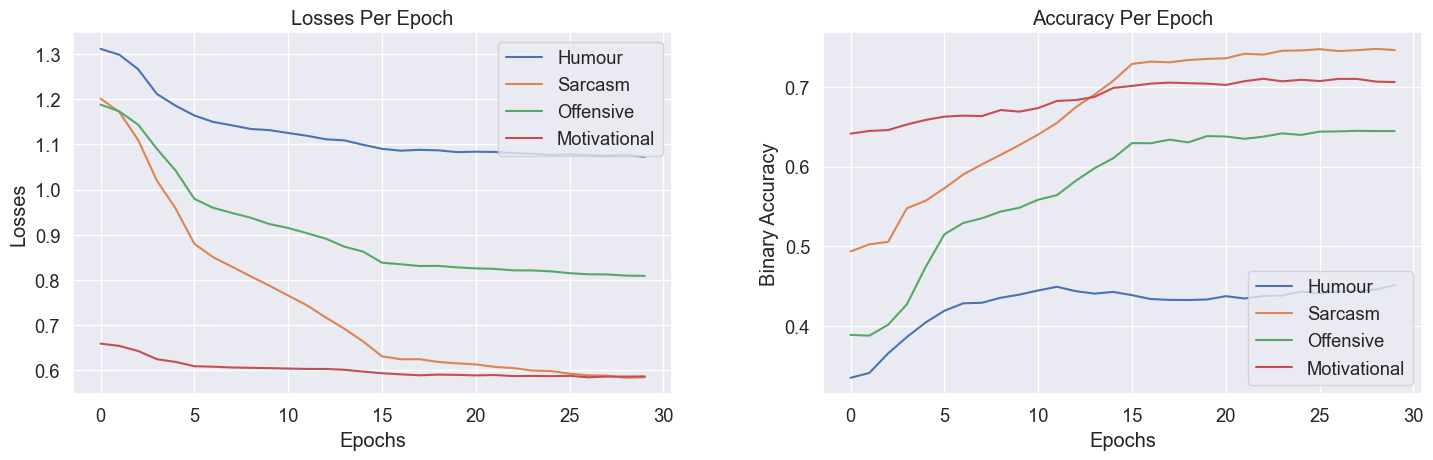

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.humuor_loss, label='Humour')
axes[0].plot(df_history.sarcasm_loss, label='Sarcasm')
axes[0].plot(df_history.offensive_loss, label='Offensive')
axes[0].plot(df_history.motivational_loss, label='Motivational')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[0].set_title('Losses Per Epoch')
axes[0].legend(loc='upper right')

axes[1].plot(df_history.humuor_sparse_categorical_accuracy, label='Humour')
axes[1].plot(df_history.sarcasm_sparse_categorical_accuracy, label='Sarcasm')
axes[1].plot(df_history.offensive_sparse_categorical_accuracy, label='Offensive')
axes[1].plot(df_history.motivational_sparse_categorical_accuracy, label='Motivational')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Binary Accuracy')
axes[1].set_title('Accuracy Per Epoch')
axes[1].legend(loc='lower right')
plt.show()

In [44]:
evaluate = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = {"sarcasm": y_test.sarcasm,
                         "humuor": y_test.humour,
                         "offensive": y_test.offensive,
                         "motivational": y_test.motivational},
                    batch_size=32,
                   )

44/44 [==============================] - 114s 3s/step - loss: 7.0246 - humuor_loss: 1.7549 - sarcasm_loss: 2.8307 - offensive_loss: 1.7396 - motivational_loss: 0.6994 - humuor_sparse_categorical_accuracy: 0.2899 - sarcasm_sparse_categorical_accuracy: 0.2956 - offensive_sparse_categorical_accuracy: 0.3457 - motivational_sparse_categorical_accuracy: 0.5841


In [45]:
print("Evaluation Loss: ", evaluate[0])
print("Evaluation Loss on Humuor", evaluate[1])
print("Evaluation Loss on Sarcasm", evaluate[2])
print("Evaluation Loss on Offensive", evaluate[3])
print("Evaluation Loss on Motivational", evaluate[4])
print("Evaluation Accuracy on Humuor", evaluate[5])
print("Evaluation Accuracy on Sarcasm", evaluate[6])
print("Evaluation Accuracy on Offensive", evaluate[7])
print("Evaluation Accuracy on Motivational", evaluate[8])

Evaluation Loss:  7.024631500244141
Evaluation Loss on Humuor 1.7549372911453247
Evaluation Loss on Sarcasm 2.8306753635406494
Evaluation Loss on Offensive 1.739617109298706
Evaluation Loss on Motivational 0.6994025707244873
Evaluation Accuracy on Humuor 0.28990694880485535
Evaluation Accuracy on Sarcasm 0.2956334948539734
Evaluation Accuracy on Offensive 0.3457408845424652
Evaluation Accuracy on Motivational 0.584108829498291


In [46]:
predictions = model.predict(x = {"image_input": X_test, "text": X_text_test})

44/44 [==============================] - 116s 3s/step


In [47]:
humuor_pred = np.array(predictions[0])
sarcasm_pred = np.array(predictions[1])
offensive_pred = np.array(predictions[2])
motivational_pred = np.array(predictions[3])

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_paths = 'C:/Users/VISHRUTH NIMALAN/Downloads/archive/memotion_dataset_7k/images'

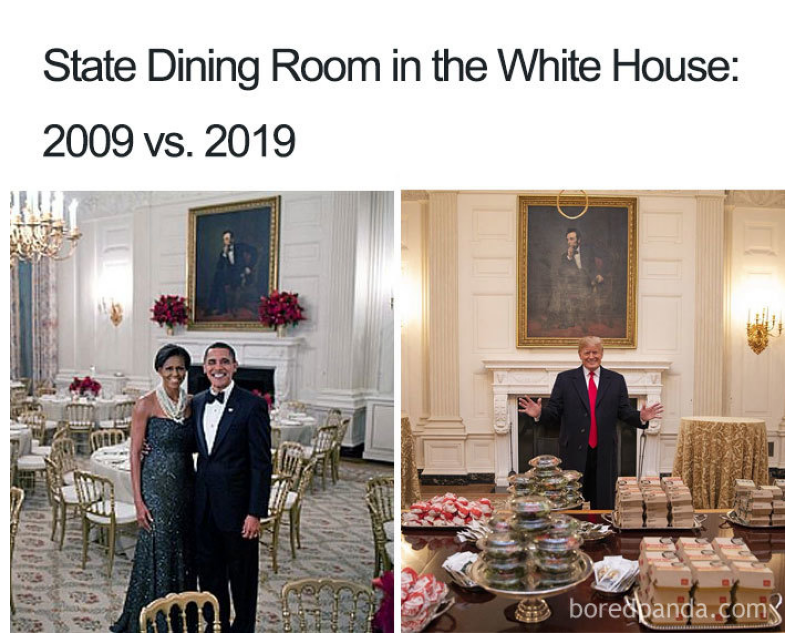

In [55]:
image_path1 = os.path.join(image_paths, f'image_12.jpg')
if not os.path.exists(image_path1):
    print(f"Image 12 not found in the directory.")
else:
    img = mpimg.imread(image_path1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

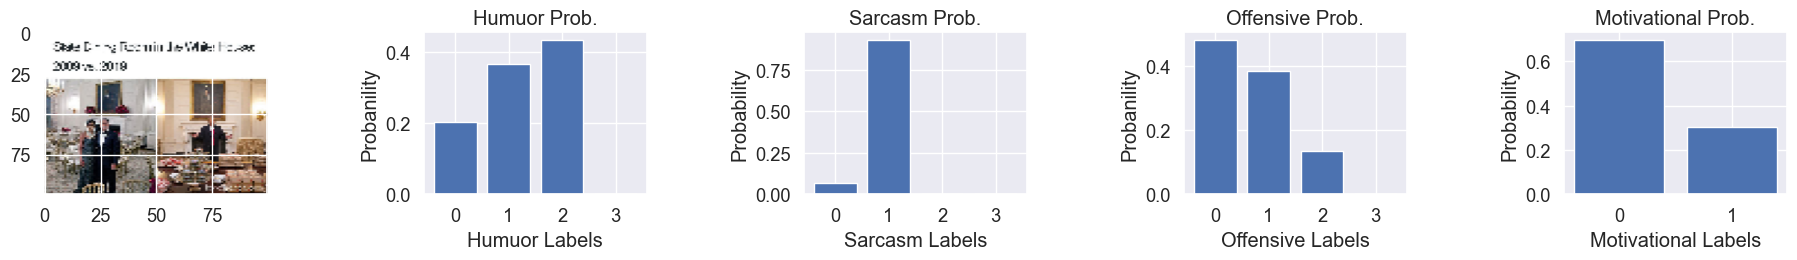

humour          2
sarcasm         1
offensive       0
motivational    0
Name: 2307, dtype: int64


In [56]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]

axes[0].imshow(X[11,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[11,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[11,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[11,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[11,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[11,:])

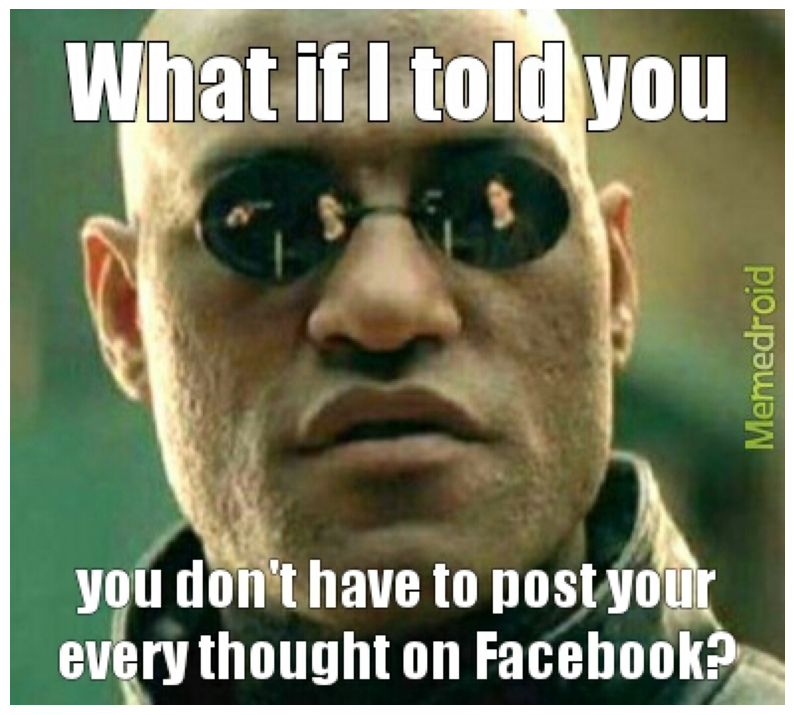

In [119]:
image_path = os.path.join(image_paths, f'image_116.jpeg')
if not os.path.exists(image_path):
    print(f"Image 116 not found in the directory.")
else:
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

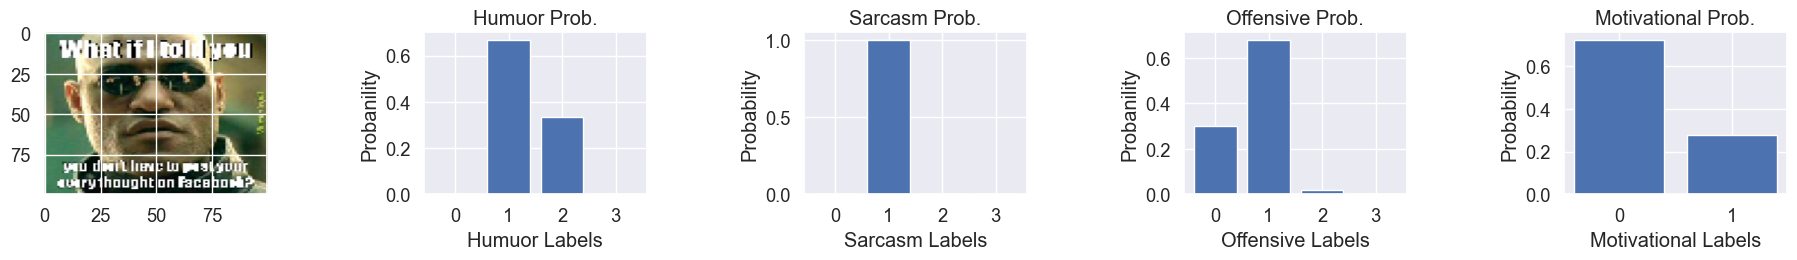

humour          1
sarcasm         0
offensive       0
motivational    0
Name: 6626, dtype: int64


In [116]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]

axes[0].imshow(X[115,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[115,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[115,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[115,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[115,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[115,:])

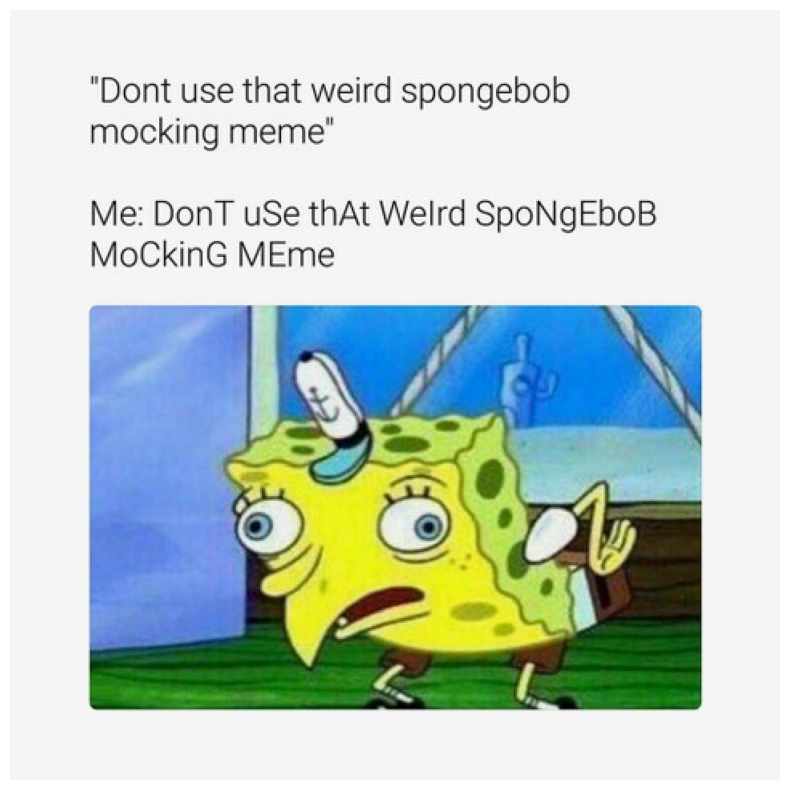

In [103]:
image_path1 = os.path.join(image_paths, f'image_276.jpg')
if not os.path.exists(image_path1):
    print(f"Image 276 not found in the directory.")
else:
    img = mpimg.imread(image_path1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

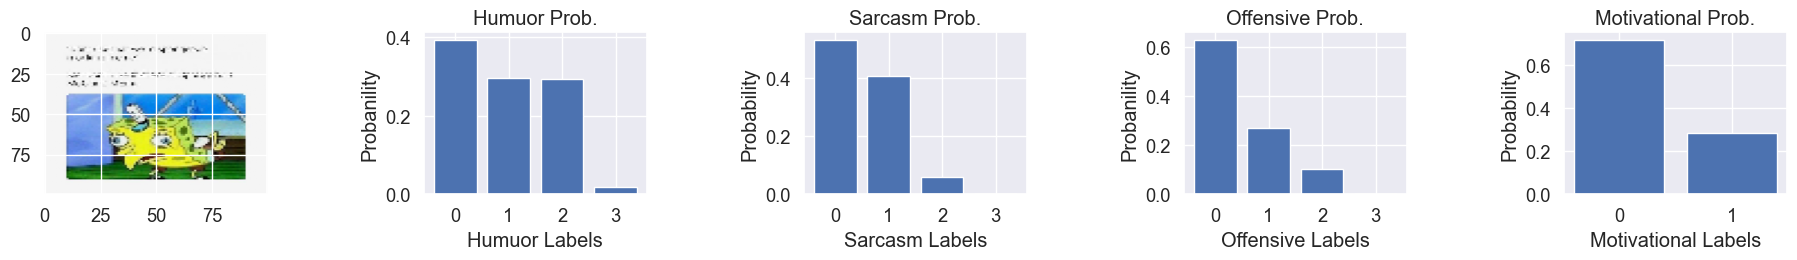

humour          1
sarcasm         0
offensive       0
motivational    0
Name: 6063, dtype: int64


In [105]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]

axes[0].imshow(X[274,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[274,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[274,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[274,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[274,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[274,:])

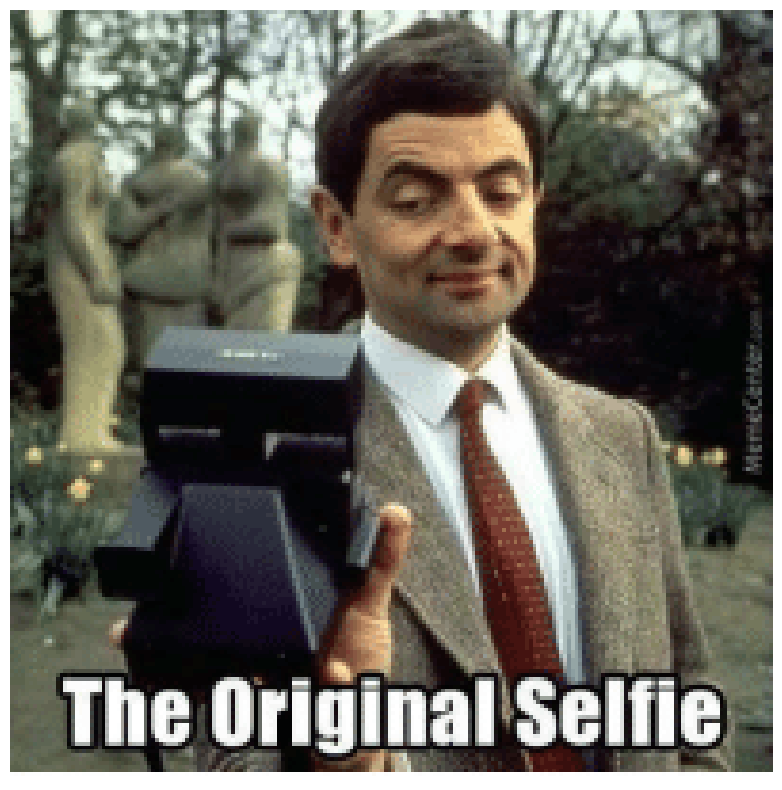

In [102]:
image_path1 = os.path.join(image_paths, f'image_252.png')
if not os.path.exists(image_path1):
    print(f"Image 252 not found in the directory.")
else:
    img = mpimg.imread(image_path1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

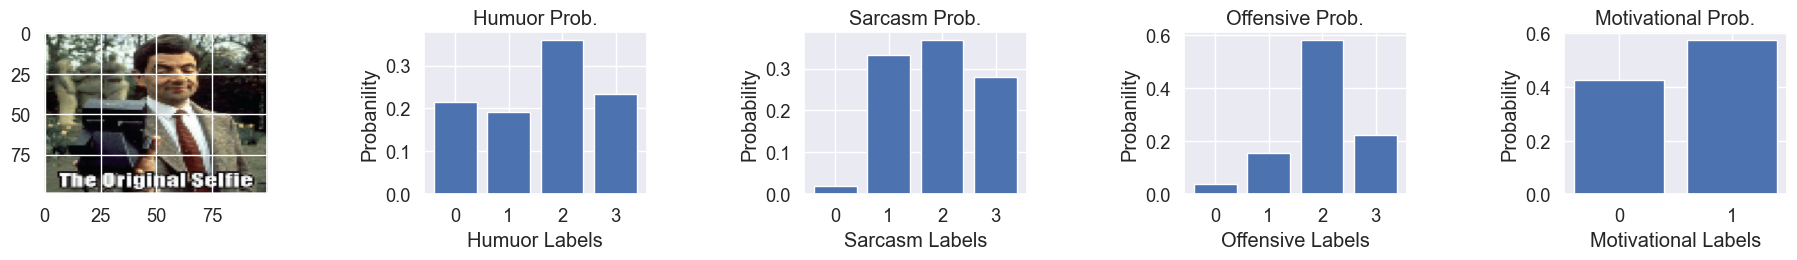

humour          2
sarcasm         2
offensive       2
motivational    1
Name: 3694, dtype: int64


In [100]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = [0, 1, 2, 3]

axes[0].imshow(X[250,:,:,:], aspect='auto')

axes[1].bar(x, humuor_pred[250,:])
axes[1].set_xlabel('Humuor Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)

axes[2].bar(x, sarcasm_pred[250,:])
axes[2].set_xlabel('Sarcasm Labels')
axes[2].set_ylabel('Probability')
axes[2].set_title('Sarcasm Prob.')
axes[2].set_xticks(x)

axes[3].bar(x, offensive_pred[250,:])
axes[3].set_xlabel('Offensive Labels')
axes[3].set_ylabel('Probanility')
axes[3].set_title('Offensive Prob.')
axes[3].set_xticks(x)

axes[4].bar([0, 1], motivational_pred[250,:])
axes[4].set_xlabel('Motivational Labels')
axes[4].set_ylabel('Probability')
axes[4].set_title('Motivational Prob.')
axes[4].set_xticks([0, 1])
plt.show()

print(y_test.iloc[250,:])